# NEU502b fMRI Visual Control Block

In [1]:
import os, warnings
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
task = 'visualcontrol'
spaces = ['fsaverage5.L','fsaverage5.R']

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Generate Task Regressors

In [2]:
from scripts.spm_hrf import spm_hrf

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Task metadata.
n_acq = 250
tr = 1

## Define upsampling level.
sfreq = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', 'regressors')
if not os.path.isdir(out_dir): os.makedirs(out_dir)

## Define TR onsets.
tr_onsets = np.arange(0, n_acq, tr)
    
## Generate HRF.
hrf = spm_hrf(1/sfreq)

for subj in subjects:
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare events.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Load events file.
    f = os.path.join('raw', subj, 'func', '%s_task-%s_events.tsv' %(subj,task))
    events = read_csv(f, sep='\t')
    
    ## Drop fixation cross.
    events = events[events.event != 'Fixation cross']
    
    ## Round onset times.
    events['onset'] = events['onset'].round(int(np.log10(sfreq)))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Generate task regressors.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize boxcars.
    times = np.linspace(0, n_acq + 1/sfreq, n_acq * sfreq).round(int(np.log10(sfreq)))
    boxcars = np.zeros_like(times)
    
    ## Generate boxcars.
    for onset, duration in events[['onset','duration']].values:
        ix = np.logical_and(times >= onset, times <= onset + duration)
        boxcars[ix] += 1
        
    ## Generate estimated hemodynamic response.
    hemo = np.convolve(boxcars, hrf)[:times.size]
    
    ## Downsample regressors.
    boxcars = boxcars[np.in1d(times, tr_onsets)]
    hemo = hemo[np.in1d(times, tr_onsets)]
    times = times[np.in1d(times, tr_onsets)]
    
    ## Scale estimated hemodynamic response.
    hemo /= hemo.max()
    
    ## Add 1-vector (intercept).
    regressors = hemo.reshape(-1,1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save task regressors.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Save.
    f = os.path.join(out_dir, '%s_task-%s_events.txt' %(subj, task))
    np.savetxt(f, regressors)
    
print('Done.')

Done.


### Visualize example

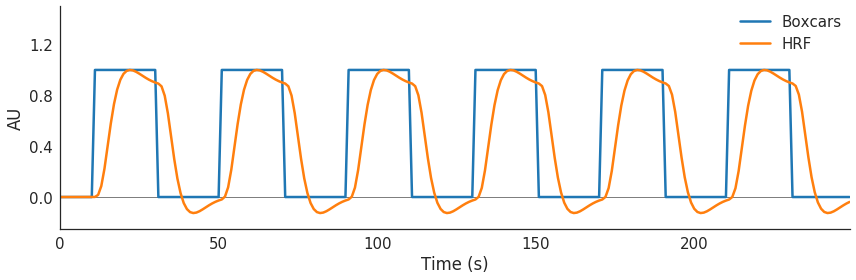

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(times, boxcars, lw=2.5, label='Boxcars')
ax.plot(times, hemo, lw=2.5, label='HRF')

## Add info.
ax.hlines(0,0,times.max(),lw=0.5,zorder=0)
ax.set(xlim=(0,times.max()), xlabel='Time (s)', ylim=(-0.25,1.5), 
       yticks=np.arange(0,1.3,0.4), ylabel='AU')
ax.legend(loc=1, borderpad=0)

sns.despine()
plt.tight_layout()

## Step 2: First Level Analysis
### Estimate first levels

In [4]:
from scripts.prewhitening import prewhiten_data
from scripts.permutations import permutation_testing
from scripts.utilities import mask_insert
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Analysis parameters.
n_perm = False 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', task)
if not os.path.isdir(out_dir): os.makedirs(out_dir)

for subj in subjects:
    
    for space in spaces:
        
        if not n_perm: break
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load and prepare data.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Load task regressors.
        f = os.path.join('first_levels','regressors','%s_task-%s_events.txt' %(subj,task))
        events = np.loadtxt(f)
        if events.ndim == 1: events = events.reshape(-1,1)
        _, n_task = events.shape
        
        ## Load motion regressors.
        f = os.path.join('first_levels','regressors','%s_task-%s_motion.txt' %(subj,task))
        motion = np.loadtxt(f)
        if motion.ndim == 1: motion = motion.reshape(-1,1)
        
        ## Load task data.
        f = os.path.join('first_levels','psc','%s_task-%s_space-%s.psc.npz' %(subj,task,space))
        npz = np.load(f)
        
        ## Prepare 
        data, mask = npz['psc'], npz['mask']
        Y = data[:,mask]
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Prewhiten data.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
        ## Construct design matrix.
        X = np.concatenate([events, motion], axis=-1)
        
        ## Prewhiten data (see script for details).
        WY, WX = prewhiten_data(Y, X)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### First-level regression.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Permutation testing (see script for details.)
        B, F, p = permutation_testing(WY, WX, n_task, n_perm)
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Save results.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Save.
        f = os.path.join(out_dir, '%s_task-%s_space-%s.ces.npz' %(subj, task, space))
        np.savez_compressed(f, B=mask_insert(B,mask), F=mask_insert(F,mask), 
                            p=mask_insert(p,mask))
        
print('Done.')

Done.


### Generate surface maps 

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Significance threshold.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', task)
if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
## Redefine threshold.
threshold = -np.log10(alpha)

for subj in subjects:
    
    for space in spaces:
        
        ## Load data.
        f = os.path.join(out_dir, '%s_task-%s_space-%s.ces.npz' %(subj, task, space))
        npz = np.load(f)
        
        ## Extract PSC and p-vals corresponding to checkerboard condition.
        psc, pvals = npz['B'][0], npz['p'][0]
        
        ## Restrict to checkerboard condition.
        
        ## Threshold PSC by significance.
        psc[np.abs(pvals) < threshold] = 0
        
        ## Convert to NIFTI image.
        obj = nib.Nifti1Image(psc.reshape(-1,1,1,1), np.identity(4))
        
        ## Save.
        f = os.path.join(out_dir, '%s_task-%s_space-%s.psc.nii.gz' %(subj, task, space))
        nib.save(obj, f)

### Visualize PSC
Labels were made using *tksurfer*.

sub-01 lh psc: mu = 3.097 (sd = 2.233)
sub-01 rh psc: mu = 3.113 (sd = 1.659)
sub-02 lh psc: mu = 1.689 (sd = 1.262)
sub-02 rh psc: mu = 1.751 (sd = 1.034)


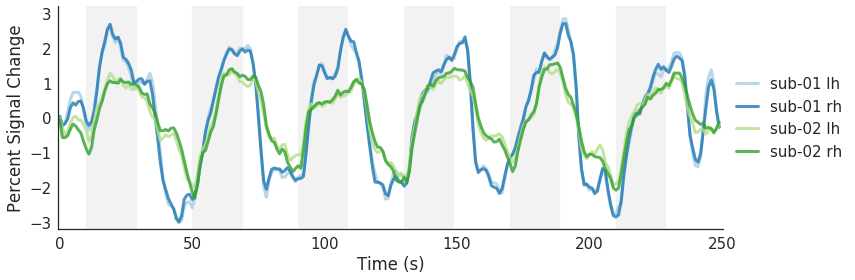

In [6]:
from mne import read_label

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))
colors = sns.color_palette("Paired", n_colors=4).as_hex()
colors = np.array(colors).reshape(2,2)

for i, subj in enumerate(subjects):
    
    for j, space in enumerate(spaces):
        
        ## Load data.
        f = os.path.join('first_levels', 'psc', '%s_task-%s_space-%s.psc.npz' %(subj, task, space))
        data = np.load(f)['psc']
        
        ## Load contrast.
        f = os.path.join(out_dir, '%s_task-%s_space-%s.psc.nii.gz' %(subj, task, space))
        psc = nib.load(f).get_data()
        
        ## Load label.
        hemi = 'lh' if space == 'fsaverage5.L' else 'rh'
        f = os.path.join(out_dir, '%s_task-%s_space-%s.psc.%s.label' %(subj, task, space, hemi))
        label = read_label(f)
        
        ## Mask data by label.
        data = data[:,label.vertices].mean(axis=-1)
        psc = psc[label.vertices]
        
        ## Print info.
        print('%s %s psc: mu = %0.3f (sd = %0.3f)' %(subj, hemi, psc.mean(), psc.std()))
        
        ## Plot.
        ax.plot(data, lw=3, label='%s %s' %(subj, hemi), color=colors[i,j], alpha=0.8)
        
## Add info.
for tmin, tmax in zip(np.arange(10,250,40), np.arange(30,250,40)):
    ax.fill_between(np.arange(tmin,tmax), -3.2, 3.2, color='0.95')
ax.set(xlim=(-0.5, 250.5), xlabel='Time (s)', ylim=(-3.2,3.2), 
       ylabel='Percent Signal Change')
        
ax.legend(loc=7, bbox_to_anchor=(1.2,0.5), handlelength=1.5)
sns.despine()
plt.tight_layout()